<h1> Insurance Cost Predictor Using Regression


This project implements regression to build a model that predicts insurance costs for an individual.
<br>The dataset includes the following feature sets: age (integer), sex (categorical), BMI (Body Mass Index, float), number of children (integer), smoker status (categorical), and region (categorical). The target variable is charges (float).
<br>In this project, five popular regression algorithms—<i>Multiple Linear Regression, Decision Tree Regression, Random Forest Regression, K-Nearest Neighbors Regression, and Support Vector Regression</i>—are fitted and tested on the dataset, with their accuracy metrics compared. The most accurate algorithm is then used for further predictions.

<i> Imports</i>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

Reading the dataset & printing head and tail

In [2]:
df=pd.read_csv("medical_insurance.csv")
print(df.head().to_string())
print(df.tail().to_string())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
      age     sex     bmi  children smoker     region      charges
2767   47  female  45.320         1     no  southeast   8569.86180
2768   21  female  34.600         0     no  southwest   2020.17700
2769   19    male  26.030         1    yes  northwest  16450.89470
2770   23    male  18.715         0     no  northwest  21595.38229
2771   54    male  31.600         0     no  southwest   9850.43200


Checking fot outliers

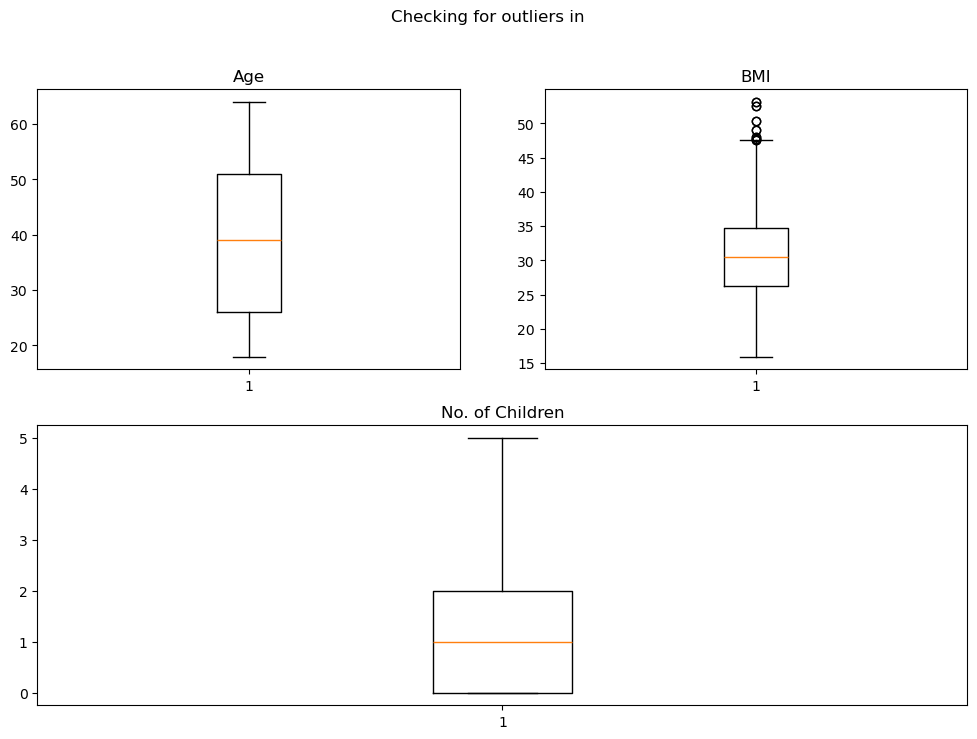

In [3]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.boxplot(data=df,x='age')
plt.title("Age")
plt.subplot(2,2,2)
plt.boxplot(data=df,x='bmi')
plt.title("BMI")
plt.subplot(2,2,(3,4))
plt.boxplot(data=df,x='children')
plt.title("No. of Children")
plt.suptitle("Checking for outliers in")
plt.show()

Outliers are found in the BMI column. Rows are dropped using the IQR rule

In [4]:
Q1=df['bmi'].quantile(0.25)
Q3=df['bmi'].quantile(0.75)

IQR=Q3-Q1
lower_bound= Q1-1.5*IQR
upper_bound= Q3+1.5*IQR
print(lower_bound,upper_bound)

df_filtered=df[(df['bmi']>=lower_bound) & (df['bmi']<47)] # upper bound = 47 removes all outliers in one step. If not, this whole step has to be
                                                          # repeated 2 or more times.
print(df_filtered.shape)
print(df.shape)

13.394999999999992 47.59500000000001
(2754, 7)
(2772, 7)


Dataset after dropping the outliers

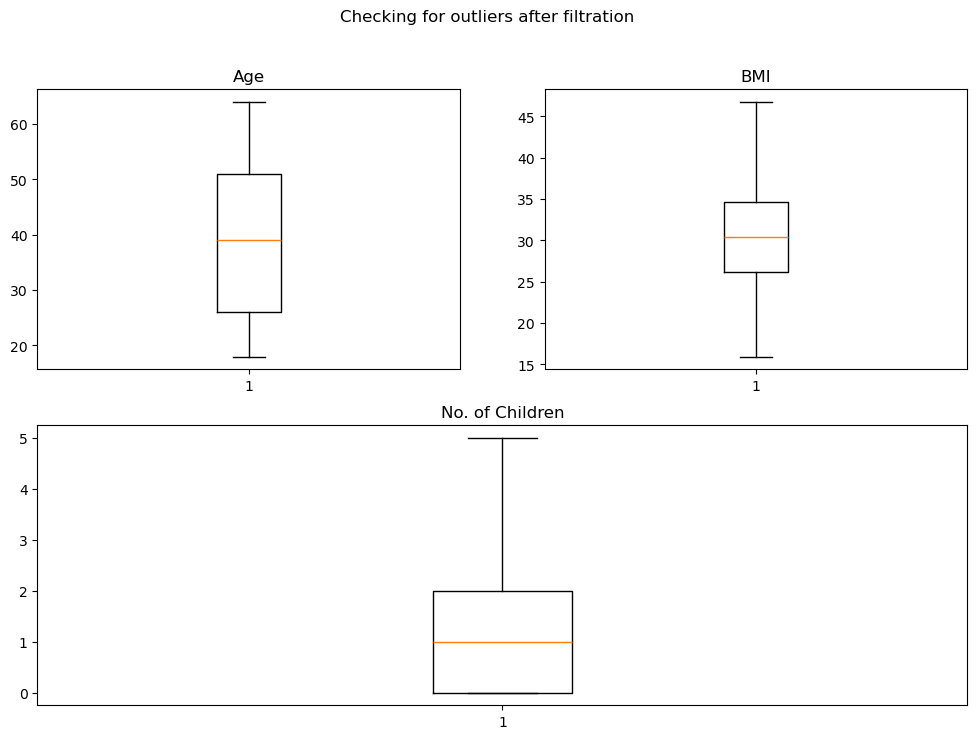

In [5]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.boxplot(data=df_filtered,x='age')
plt.title("Age")
plt.subplot(2,2,2)
plt.boxplot(data=df_filtered,x='bmi')
plt.title("BMI")
plt.subplot(2,2,(3,4))
plt.boxplot(data=df_filtered,x='children')
plt.title("No. of Children")
plt.suptitle("Checking for outliers after filtration")
plt.show()

Checking for null values

In [6]:
df=df_filtered
print(df.shape)
print(df.isnull().sum())


(2754, 7)
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Splitting the features and target variable

In [7]:
x=df.iloc[:,:-1].values
y=df.iloc[:,-1].values

print(x)
print(y)

[[19 'female' 27.9 0 'yes' 'southwest']
 [18 'male' 33.77 1 'no' 'southeast']
 [28 'male' 33.0 3 'no' 'southeast']
 ...
 [19 'male' 26.03 1 'yes' 'northwest']
 [23 'male' 18.715 0 'no' 'northwest']
 [54 'male' 31.6 0 'no' 'southwest']]
[16884.924    1725.5523   4449.462   ... 16450.8947  21595.38229
  9850.432  ]


Encoding the categorical values using LabelEncoder

In [8]:
labEnc_sex=LabelEncoder()
labEnc_smoker=LabelEncoder()
labEnc_region=LabelEncoder()
x[:, 1] = labEnc_sex.fit_transform(x[:, 1])  # Gender: Female 0, Male 1
x[:, 4] = labEnc_smoker.fit_transform(x[:, 4])  # Smoker: Yes 1, No 0
x[:, 5] = labEnc_region.fit_transform(x[:, 5])  # Region: Northeast 0, Northwest 1, Southeast 2, Southwest 3
print(x)

[[19 0 27.9 0 1 3]
 [18 1 33.77 1 0 2]
 [28 1 33.0 3 0 2]
 ...
 [19 1 26.03 1 1 1]
 [23 1 18.715 0 0 1]
 [54 1 31.6 0 0 3]]


Using ColumnTransformer to convert the categorical columns into multiple columns


In [9]:
ct=ColumnTransformer(
    transformers=[
        ('onehot',OneHotEncoder(drop='first'),[1,4,5]) # Dropping the dummy variable column(1st column after each transform) using drop='first'
    ],
    remainder='passthrough'
)

x=ct.fit_transform(x)
xdf=pd.DataFrame(x)
print(x[0])

[0.0 1.0 0.0 0.0 1.0 19 27.9 0]


Splitting the training data and test data and setting the random state

In [10]:
x_test,x_train,y_test,y_train=train_test_split(
    x,y,test_size=0.25,random_state=2
)

Scaling the x values for KNN and SVR algorithms.

In [11]:
ss_x = StandardScaler()
scaled_x_train = ss_x.fit_transform(x_train)
scaled_x_test = ss_x.transform(x_test)

Defining a function for model fitting, prediction and evaluation

In [12]:
def model_evaluation(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    r2 = metrics.r2_score(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    
    return r2, mae, rmse


models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regression": DecisionTreeRegressor(random_state=2),
    "Random Forest Regression": RandomForestRegressor(n_estimators=100, random_state=2),
    "KNN Regression": KNeighborsRegressor(n_neighbors=5),
    "SVR Regression": SVR(kernel='linear')
}

Printing out the results

In [13]:
results = []


for model_name, model in models.items():
    if model_name == "KNN Regression" or model_name == "SVR Regression":
        r2, mae, rmse = model_evaluation(model, scaled_x_train, scaled_x_test, y_train, y_test)
    else:
        r2, mae, rmse = model_evaluation(model, x_train, x_test, y_train, y_test)
    
    results.append({
        "Model": model_name,
        "R-squared": r2,
        "Mean Absolute Error": mae,
        "Root Mean Squared Error": rmse
    })


results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

                   Model  R-squared  Mean Absolute Error  Root Mean Squared Error
       Linear Regression   0.757298          4177.024841              5941.226145
Decision Tree Regression   0.790302          2285.053584              5522.504315
Random Forest Regression   0.867904          2382.813982              4383.132610
          KNN Regression   0.772153          3518.662965              5756.529252
          SVR Regression  -0.060608          7932.664225             12419.853133


From this results, we can observe that Random Forest Regression algorithm produces the best scores in accuracy and error measurements. So we will calculate the custom predictions using Random Forest Regression.

<b>For Reference:</b><br>
Gender: Female-0, Male-1<br>
Smoker: No-0, Yes-1<br>
Region: Northeast-0, Northwest-1, Southeast-2, Southwest-3

In-program custom input

In [14]:
x_custom = np.array([[23, 'male', 27.8, 0, 'yes', 'southeast']], dtype=object)

x_custom[:, 1] = labEnc_sex.transform(x_custom[:, 1])
x_custom[:, 4] = labEnc_smoker.transform(x_custom[:, 4])
x_custom[:, 5] = labEnc_region.transform(x_custom[:, 5])

x_custom = ct.transform(x_custom)
y_custom = models['Random Forest Regression'].predict(x_custom)

print("Custom input prediction:",y_custom[0].round(2))

Custom input prediction: 28527.54


Now we take user input and predict from it

In [15]:
def get_input():
    age = int(input("Enter the age: "))
    bmi = float(input("Enter BMI: "))
    children = int(input("Enter no. of children: "))
    
    while True:
        print("\nSelect Gender")
        print("1: Female")
        print("2: Male")
        gender_choice = input("Enter either 1 or 2: ")
        if gender_choice == '1':
            gender = 'female'
            break
        elif gender_choice == '2':
            gender = 'male'
            break
        else:
            print("Invalid input. Please enter 1 for Female or 2 for Male.")

    while True:
        print("\nAre you a smoker?")
        print("1: Yes")
        print("2: No")
        smoker_choice = input("Enter 1 for Yes or 2 for No: ")
        if smoker_choice == '1':
            smoker = 'yes'
            break
        elif smoker_choice == '2':
            smoker = 'no'
            break
        else:
            print("Invalid input. Please enter 1 for Yes or 2 for No.")
    
    while True:
        print("\nSelect region:")
        print("1: Northeast")
        print("2: Northwest")
        print("3: Southeast")
        print("4: Southwest")
        region_choice = input("Enter 1, 2, 3, or 4 for the corresponding region: ")
        if region_choice == '1':
            region = 'northeast'
            break
        elif region_choice == '2':
            region = 'northwest'
            break
        elif region_choice == '3':
            region = 'southeast'
            break
        elif region_choice == '4':
            region = 'southwest'
            break
        else:
            print("Invalid input. Please enter a number from 1 to 4 for the region.")

    return np.array([[age, gender, bmi, children, smoker, region]], dtype=object)

x_user = get_input()
cols=['Age','Gender','BMI','No. of Children','Smoker','Region']
userDF=pd.DataFrame(x_user,columns=cols)
print('\nUser Input Data',userDF.to_string(index=False))




Select Gender
1: Female
2: Male

Are you a smoker?
1: Yes
2: No

Select region:
1: Northeast
2: Northwest
3: Southeast
4: Southwest

User Input Data Age Gender   BMI No. of Children Smoker    Region
 25 female  28.5               0    yes southwest


In [16]:
x_user[:,1]=labEnc_sex.transform(x_user[:,1])
x_user[:,4]=labEnc_smoker.transform(x_user[:,4])
x_user[:,5]=labEnc_region.transform(x_user[:,5])
x_user=ct.transform(x_user)
y_user=models['Random Forest Regression'].predict(x_user)
print("Insurance cost prediction for user input data is:",y_user[0].round(2))

Insurance cost prediction for user input data is: 30654.88


# Conclusion
This project implemented some popular regression models to determine the most effective algorithm for predicting insurance costs based on the given data. By comparing accuracy scores and error metrics, the project identified the Random Forest Regression algorithm as the most suitable model for this dataset. Random Forest Regression was ultimately used to predict insurance costs for both sample input data and custom user input.